# The dataset has four main elements:

### X_jets – Three-channel images, all 125 × 125 pixels in size.

### m0 – Stands for mass.

### pt – Stands for transverse momentum.

### y – Refers to labels.

### State-of-the-art Jet Image Taggers make use of a 4-tuple representation when performing classification.

### For this particular screening task, I am implementing a Variational Autoencoder (VAE) to examine and process Jet Images as needed.

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from skimage.transform import resize
from torch.distributions import Normal
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
file_path = "/kaggle/input/autoencoder-data/quark-gluon_data-set_n139306.hdf5"
def explore_hdf5(file):
    with h5py.File(file, "r") as f:
        print("Keys in dataset:", list(f.keys()))
        for key in f.keys():
            print(f"Shape of {key}: {f[key].shape}")

explore_hdf5(file_path)

Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Shape of X_jets: (139306, 125, 125, 3)
Shape of m0: (139306,)
Shape of pt: (139306,)
Shape of y: (139306,)


In [4]:
def load_data(file_name, sample_size):
    with h5py.File(file_name, 'r') as f:
        print("Dataset keys:", list(f.keys()))
        print("Total images:", len(f['X_jets']))
        print("Image dimensions:", f['X_jets'].shape[1:])
        return np.array(f['X_jets'][:sample_size]), np.array(f['y'][:sample_size])

X, y = load_data(file_path, 10000)

Dataset keys: ['X_jets', 'm0', 'pt', 'y']
Total images: 139306
Image dimensions: (125, 125, 3)


# This visualize_channels function will plot and compare a multi-channel jet image by showing:

The combined image (all three channels combined) on top.
Single channel images (Track, ECAL, and HCAL) underneath it, with 'viridis' colormap for better visualization.

In [5]:
def visualize_channels(image_data, sample_index=129):
    X_sample = image_data[sample_index]
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))
    axes[0].imshow(X_sample)
    axes[0].set_title('Combined')
    channel_labels = ['Track', 'ECAL', 'HCAL']
    for i in range(3):
        img = axes[i+1].imshow(X_sample[:, :, i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
        axes[i+1].set_title(channel_labels[i])
        fig.colorbar(img, ax=axes[i+1], shrink=0.5)
    plt.show()

# This function intensity calculates and prints statistical information regarding the intensity values over various channels in the dataset.

Traverses all three channels (Track, ECAL, HCAL) to calculate:

Maximum and Minimum intensity values
Mean intensity value
Standard deviation of intensity distribution
Calculates an overall intensity image by adding up the three channels and studying its statistical properties.

In [6]:
def intensity(X, y):
    for i, channel_name in enumerate(["Track", "ECAL", "HCAL"]):
        print(f"Max value of intensity along {channel_name} channel: {np.max(X[:,:,:,i])}, Min value: {np.min(X[:,:,:,i])}")
        print(f"Mean intensity value along {channel_name} channel: {np.mean(X[:,:,:,i])}")
        print(f"Standard Deviation: {np.std(X[:,:,:,i])}\n")

    combined_dataset = np.sum(X, axis=-1, keepdims=True) 

    print("Max value of intensity in combined channel image:", np.max(combined_dataset[:,:,:,0]), "Min value:", np.min(combined_dataset[:,:,:,0]))
    print("Mean intensity value in combined channel:", np.mean(combined_dataset[:,:,:,0]))
    print("Standard Deviation:", np.std(combined_dataset[:,:,:,0]), "\n")



### Plotting the provided dataset, we understand that intensity values (calorimeter hits) in all the channels (Track, ECAL, HCAL) fluctuate highly, and that data pre-processing needs to be done.

Max value of intensity along Track channel: 10.088105201721191, Min value: 0.0
Mean intensity value along Track channel: 7.841042679501697e-05
Standard Deviation: 0.0038757636211812496

Max value of intensity along ECAL channel: 9.334086418151855, Min value: 0.0
Mean intensity value along ECAL channel: 4.9682072130963206e-05
Standard Deviation: 0.002107673790305853

Max value of intensity along HCAL channel: 0.3597966134548187, Min value: 0.0
Mean intensity value along HCAL channel: 3.119495158898644e-05
Standard Deviation: 0.0005133272497914732

Max value of intensity in combined channel image: 12.1562605 Min value: 0.0
Mean intensity value in combined channel: 0.00015928746
Standard Deviation: 0.0046356586 



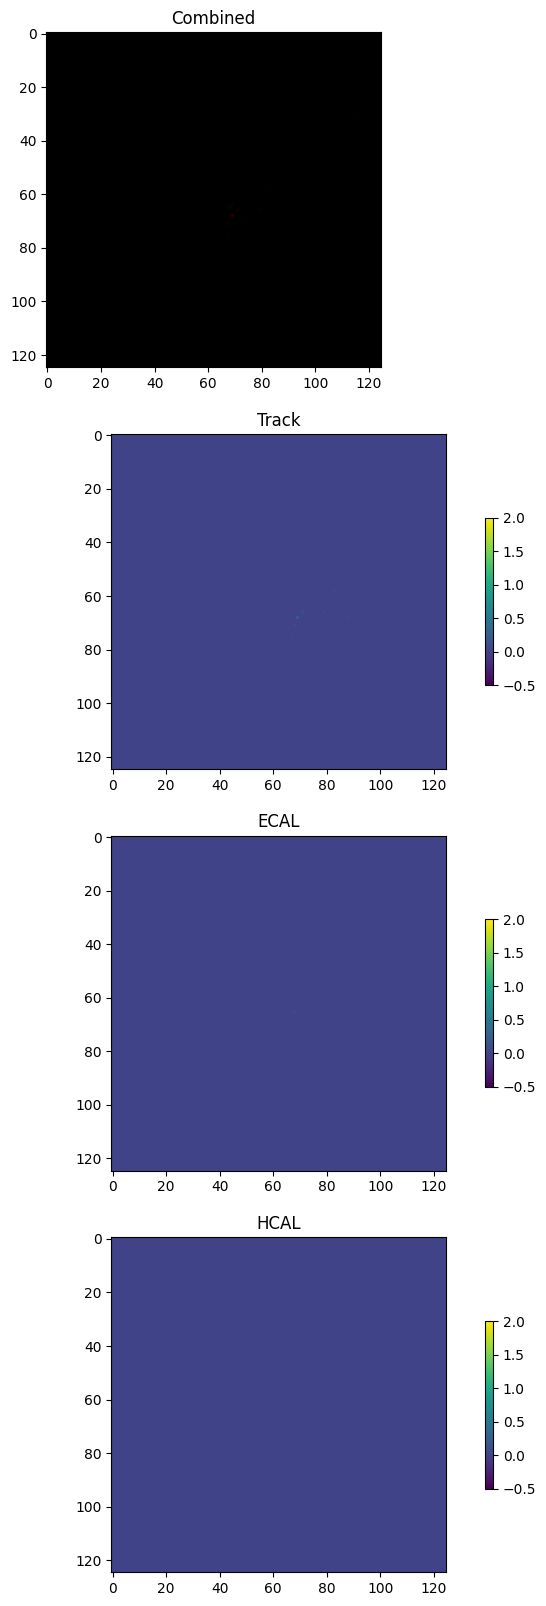

In [7]:
intensity(X,y)
visualize_channels(X)

### The preprocess_images() function scales images from (125, 125, 3) to (128, 128, 3) for uniformity with bilinear interpolation. It next normalizes pixel values to be 0 mean and 1 standard deviation, stabilizing the training. It lastly clips negative intensity values to zero, preventing invalid pixel values and lowering noise.

In [8]:
def preprocess_images(images):
    from skimage.transform import resize
    # Resizing images from (125, 125, 3) to (128, 128, 3)
    processed = np.array([resize(img, (128, 128), anti_aliasing=True) for img in images], dtype=np.float32)
    # Standardizing the distribution across all channels
    mean, std = np.mean(processed), np.std(processed)
    # Clipping negative intensity values to 0...
    return np.clip((processed - mean) / std, 0, None)

X = preprocess_images(X)

Max value of intensity along Track channel: 2362.630126953125, Min value: 0.0
Mean intensity value along Track channel: 0.04981083795428276
Standard Deviation: 1.4279361963272095

Max value of intensity along ECAL channel: 2024.9141845703125, Min value: 0.0
Mean intensity value along ECAL channel: 0.03096914105117321
Standard Deviation: 0.928253710269928

Max value of intensity along HCAL channel: 231.5849151611328, Min value: 0.0
Mean intensity value along HCAL channel: 0.018975133076310158
Standard Deviation: 0.30354058742523193

Max value of intensity in combined channel image: 3176.8376 Min value: 0.0
Mean intensity value in combined channel: 0.09975512
Standard Deviation: 1.9071503 



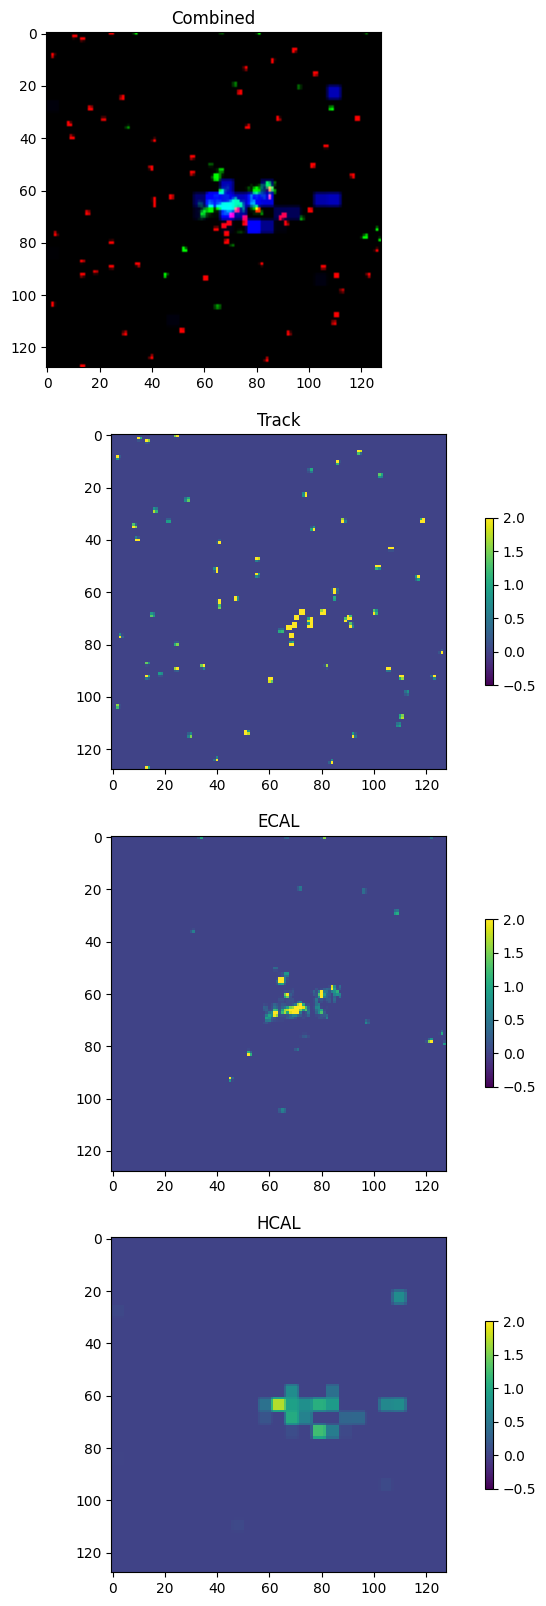

In [9]:
intensity(X,y)
visualize_channels(X)

In [10]:
class Reparameterization(nn.Module):
    def forward(self, mean, log_variance):
        batch_size, latent_dim = mean.shape
        epsilon = Normal(0, 1).sample((batch_size, latent_dim)).to(mean.device)
        return mean + torch.exp(0.5 * log_variance) * epsilon

In [11]:
class VAE_autoencoder(nn.Module):
    def __init__(self,embedding_dim):
        super(VAE_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        self.mean_layer = nn.Linear(16384, embedding_dim)
        self.logvar = nn.Linear(16384, embedding_dim)
        self.reparam = Reparameterization()

        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim,16384),
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32,3,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.Tanh()
        )

    def forward(self, x,embedding_dim):
        x = self.encoder(x)
        x = x.reshape(x.size(0),-1)
        mu = self.mean_layer(x)
        logvar = self.logvar(x)
        z = self.reparam(mu,logvar)
        z = self.decoder[0](z)  
        z = z.view(z.size(0), 256, 8, 8)  
    
        # Continue with the decoder
        x_rec = self.decoder[1:](z)  
        x_rec = (x_rec + 1) / 2  
        return x_rec,mu,logvar


In [12]:
class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCELoss()
    def forward(self, x_rec, x, mu, logvar):
        recon_loss = self.bce_loss(x_rec, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        return 500 * recon_loss + kl_loss


In [13]:
trackMax = np.max(X[:,:,:,0])
ecalMax = np.max(X[:,:,:,1])
hcalMax = np.max(X[:,:,:,2])


X[:,:,:,0] = X[:,:,:,0]/trackMax
X[:,:,:,1] = X[:,:,:,1]/ecalMax
X[:,:,:,2] = X[:,:,:,2]/hcalMax

In [14]:
intensity(X,y)

Max value of intensity along Track channel: 1.0, Min value: 0.0
Mean intensity value along Track channel: 2.108279113599565e-05
Standard Deviation: 0.0006043842295184731

Max value of intensity along ECAL channel: 1.0, Min value: 0.0
Mean intensity value along ECAL channel: 1.5294048353098333e-05
Standard Deviation: 0.0004584163543768227

Max value of intensity along HCAL channel: 1.0, Min value: 0.0
Mean intensity value along HCAL channel: 8.193597022909671e-05
Standard Deviation: 0.0013107095146551728

Max value of intensity in combined channel image: 1.6550478 Min value: 0.0
Mean intensity value in combined channel: 0.00011831283
Standard Deviation: 0.0016820203 



### Loading these datasets using standard PyTorch dataloader ->

In [15]:
X_jets_train, X_jets_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_jets_train, X_jets_val, y_train, y_val = train_test_split(X_jets_train, y_train, test_size=0.25, random_state=42)

In [16]:
class JetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        image = self.X[index].permute(2, 0, 1)
        return image, self.y[index]

    def __len__(self):
        return len(self.X)

train_dataset = JetDataset(torch.from_numpy(X_jets_train), torch.from_numpy(y_train))
val_dataset = JetDataset(torch.from_numpy(X_jets_val), torch.from_numpy(y_val))
test_dataset = JetDataset(torch.from_numpy(X_jets_test), torch.from_numpy(y_test))

In [17]:
from tqdm import tqdm

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_autoencoder(embedding_dim= 2048).to(device) 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = VAELoss()

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data = data.to(device) 
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data,embedding_dim=2048)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device) # Move data to device
            recon_batch, mu, logvar = model(data,embedding_dim=2048)
            loss = criterion(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Epoch 0: 100%|██████████| 42/42 [00:03<00:00, 10.84it/s]


Epoch: 1, Train Loss: 430.6669732956659, Val Loss: 327.4065835135324


Epoch 1: 100%|██████████| 42/42 [00:02<00:00, 15.15it/s]


Epoch: 2, Train Loss: 314.9391929989769, Val Loss: 277.26468985421315


Epoch 2: 100%|██████████| 42/42 [00:02<00:00, 15.23it/s]


Epoch: 3, Train Loss: 254.5078070504325, Val Loss: 229.20806993756975


Epoch 3: 100%|██████████| 42/42 [00:02<00:00, 15.19it/s]


Epoch: 4, Train Loss: 209.10893031529017, Val Loss: 189.1737834385463


Epoch 4: 100%|██████████| 42/42 [00:02<00:00, 15.18it/s]


Epoch: 5, Train Loss: 174.72491673060827, Val Loss: 159.96144212995256


Epoch 5: 100%|██████████| 42/42 [00:02<00:00, 15.22it/s]


Epoch: 6, Train Loss: 148.60206168038505, Val Loss: 137.2531226021903


Epoch 6: 100%|██████████| 42/42 [00:02<00:00, 15.16it/s]


Epoch: 7, Train Loss: 127.86326544625419, Val Loss: 118.80386243547711


Epoch 7: 100%|██████████| 42/42 [00:02<00:00, 15.15it/s]


Epoch: 8, Train Loss: 110.96143322899228, Val Loss: 103.72684914725167


Epoch 8: 100%|██████████| 42/42 [00:02<00:00, 15.22it/s]


Epoch: 9, Train Loss: 97.00241052536737, Val Loss: 91.04540416172573


Epoch 9: 100%|██████████| 42/42 [00:02<00:00, 15.20it/s]


Epoch: 10, Train Loss: 85.27766254970005, Val Loss: 80.40609523228237


Epoch 10: 100%|██████████| 42/42 [00:02<00:00, 15.17it/s]


Epoch: 11, Train Loss: 75.32852754138764, Val Loss: 71.23124694824219


Epoch 11: 100%|██████████| 42/42 [00:02<00:00, 15.18it/s]


Epoch: 12, Train Loss: 66.86839884803409, Val Loss: 63.51097461155483


Epoch 12: 100%|██████████| 42/42 [00:02<00:00, 15.15it/s]


Epoch: 13, Train Loss: 59.636088053385414, Val Loss: 56.79377310616629


Epoch 13: 100%|██████████| 42/42 [00:02<00:00, 15.14it/s]


Epoch: 14, Train Loss: 53.411895388648624, Val Loss: 51.006090436662944


Epoch 14: 100%|██████████| 42/42 [00:02<00:00, 15.10it/s]


Epoch: 15, Train Loss: 48.03189132327125, Val Loss: 45.84774916512625


Epoch 15: 100%|██████████| 42/42 [00:02<00:00, 15.17it/s]


Epoch: 16, Train Loss: 43.36605644226074, Val Loss: 41.50996208190918


Epoch 16: 100%|██████████| 42/42 [00:02<00:00, 15.18it/s]


Epoch: 17, Train Loss: 39.29749261765253, Val Loss: 37.648321696690154


Epoch 17: 100%|██████████| 42/42 [00:02<00:00, 15.14it/s]


Epoch: 18, Train Loss: 35.73495755876814, Val Loss: 34.31951059613909


Epoch 18: 100%|██████████| 42/42 [00:02<00:00, 15.19it/s]


Epoch: 19, Train Loss: 32.600073224022275, Val Loss: 31.319875853402273


Epoch 19: 100%|██████████| 42/42 [00:02<00:00, 15.21it/s]


Epoch: 20, Train Loss: 29.82695279802595, Val Loss: 28.776316779000418


Max value of intensity along Track channel: 1.0, Min value: 0.0
Mean intensity value along Track channel: 2.108279113599565e-05
Standard Deviation: 0.0006043842295184731

Max value of intensity along ECAL channel: 1.0, Min value: 0.0
Mean intensity value along ECAL channel: 1.5294048353098333e-05
Standard Deviation: 0.0004584163543768227

Max value of intensity along HCAL channel: 1.0, Min value: 0.0
Mean intensity value along HCAL channel: 8.193597022909671e-05
Standard Deviation: 0.0013107095146551728

Max value of intensity in combined channel image: 1.6550478 Min value: 0.0
Mean intensity value in combined channel: 0.00011831283
Standard Deviation: 0.0016820203 



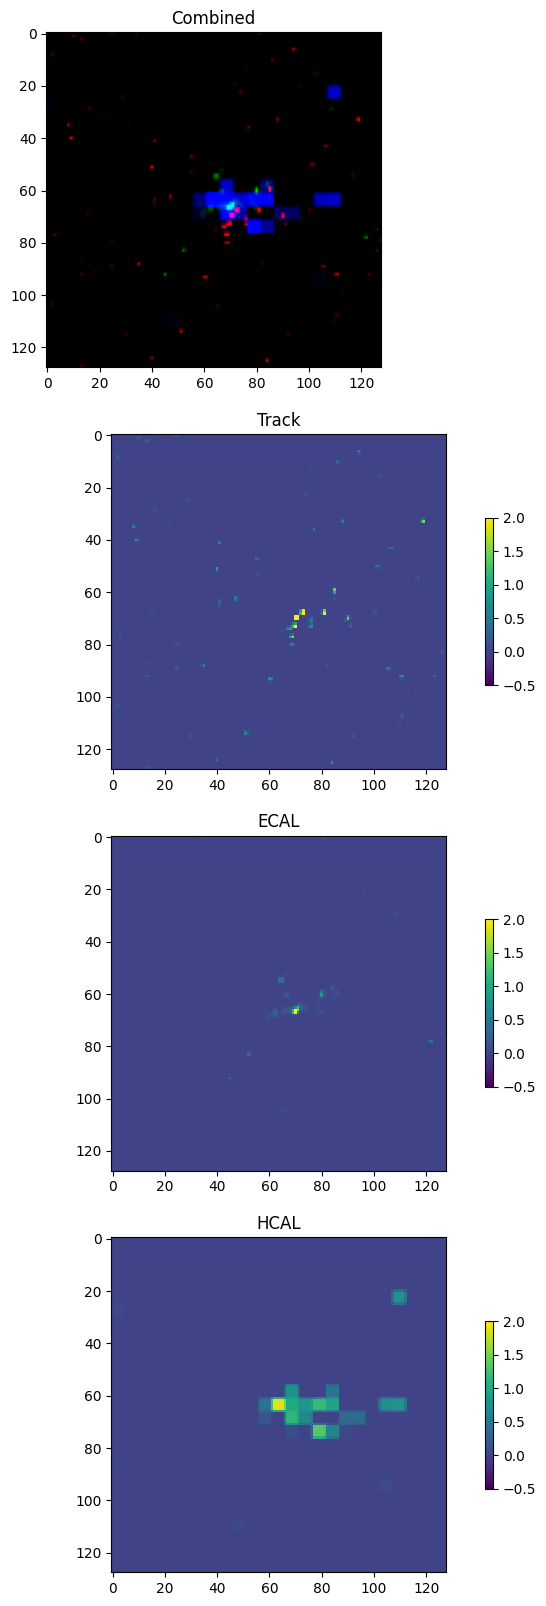

In [19]:
intensity(X,y)
visualize_channels(X*255)

In [20]:
def reconstruct_image(original_image, model):
    original_image = torch.from_numpy(original_image).float().to(device)
    
    original_image = original_image.unsqueeze(0) 

    with torch.no_grad():
        reconstructed_image = model(original_image,embedding_dim=2048)  

    reconstructed_image = reconstructed_image[0].squeeze(0).cpu().numpy().astype(np.float32)  # (3, 128, 128)
    
    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))

    return reconstructed_image


In [21]:
images = X[0]
images[:,:,0] = (images[:,:,0] - np.min(images[:,:,0]))/(np.max(images[:,:,0]) - np.min(images[:,:,0]))
images[:,:,1] = (images[:,:,1] - np.min(images[:,:,1]))/(np.max(images[:,:,1]) - np.min(images[:,:,1]))
images[:,:,2] = (images[:,:,2] - np.min(images[:,:,2]))/(np.max(images[:,:,2]) - np.min(images[:,:,2]))
images = np.transpose(images, (2, 1, 0))
x_rec = reconstruct_image(images, model)

reconstructed_image_scaled = x_rec

For the first image among the batch passed : 
Max value of intensity along Track channel: 1.0, Min value: 0.0
Max value of intensity along ECAL channel: 1.0, Min value: 0.0
Max value of intensity along HCAL channel: 1.0, Min value: 0.0


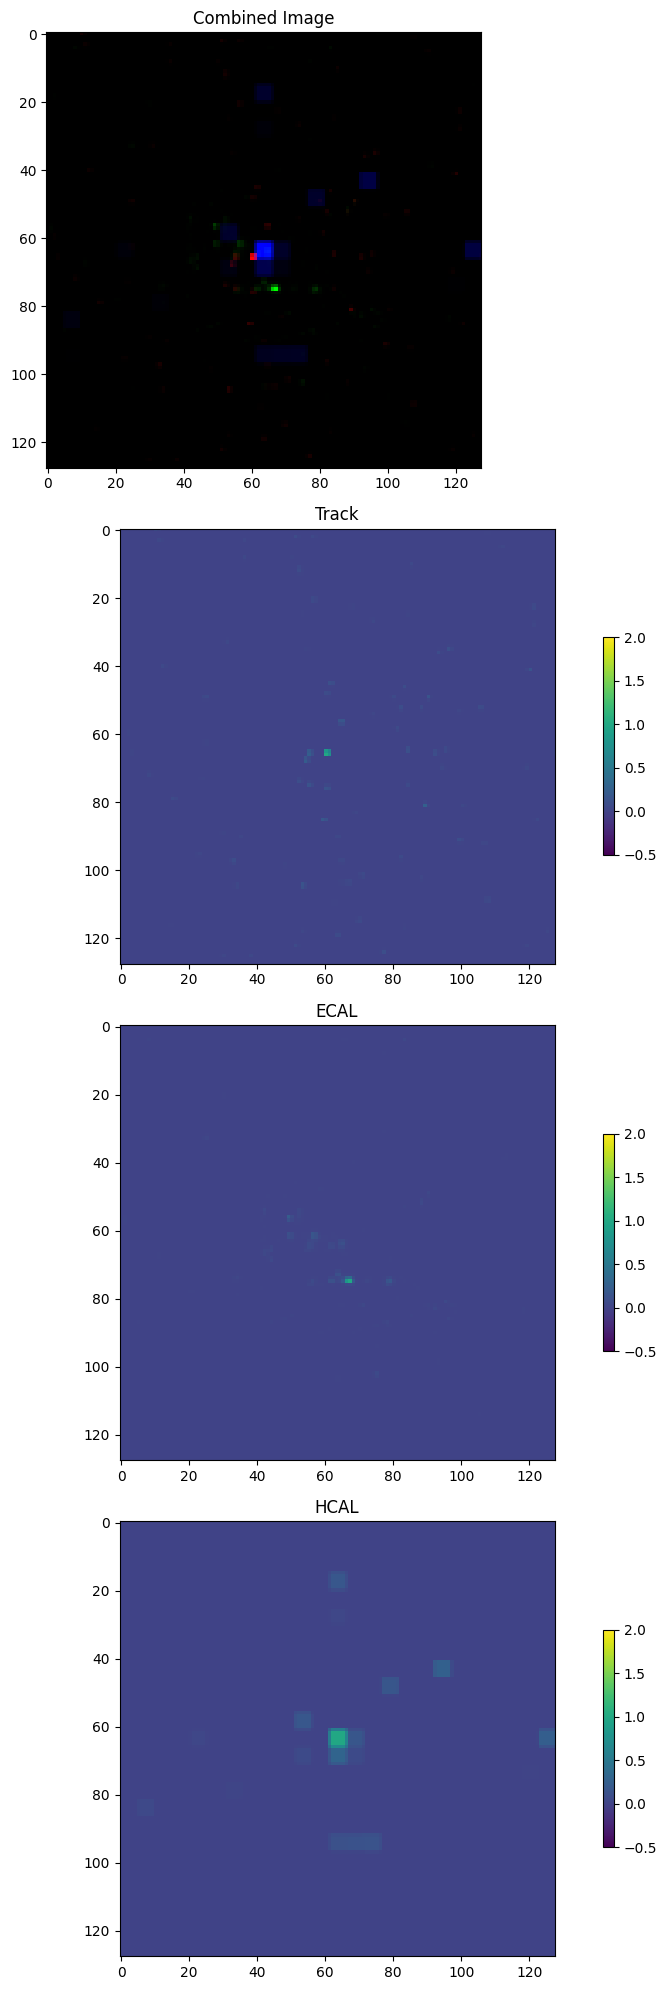

In [22]:

X_sample = X[0]

print("For the first image among the batch passed : ")
for i, label in enumerate(["Track", "ECAL", "HCAL"]):
    print(f"Max value of intensity along {label} channel: {np.max(X_sample[:,:,i])}, Min value: {np.min(X_sample[:,:,i])}")

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

axs[0].imshow(X_sample)
axs[0].set_title('Combined Image')

channel_labels = ['Track', 'ECAL', 'HCAL']
for i in range(3):
    img = axs[i+1].imshow(X_sample[:, :, i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axs[i+1].set_title(channel_labels[i])
    fig.colorbar(img, ax=axs[i+1], shrink=0.5)

plt.tight_layout()
plt.show()


For the first image among the batch passed : 
Max value of intensity along Track channel: 0.17813146114349365, Min value: 0.0008053779602050781
Max value of intensity along ECAL channel: 0.25496789813041687, Min value: 0.00033345818519592285
Max value of intensity along HCAL channel: 0.4387306571006775, Min value: 0.0025491416454315186


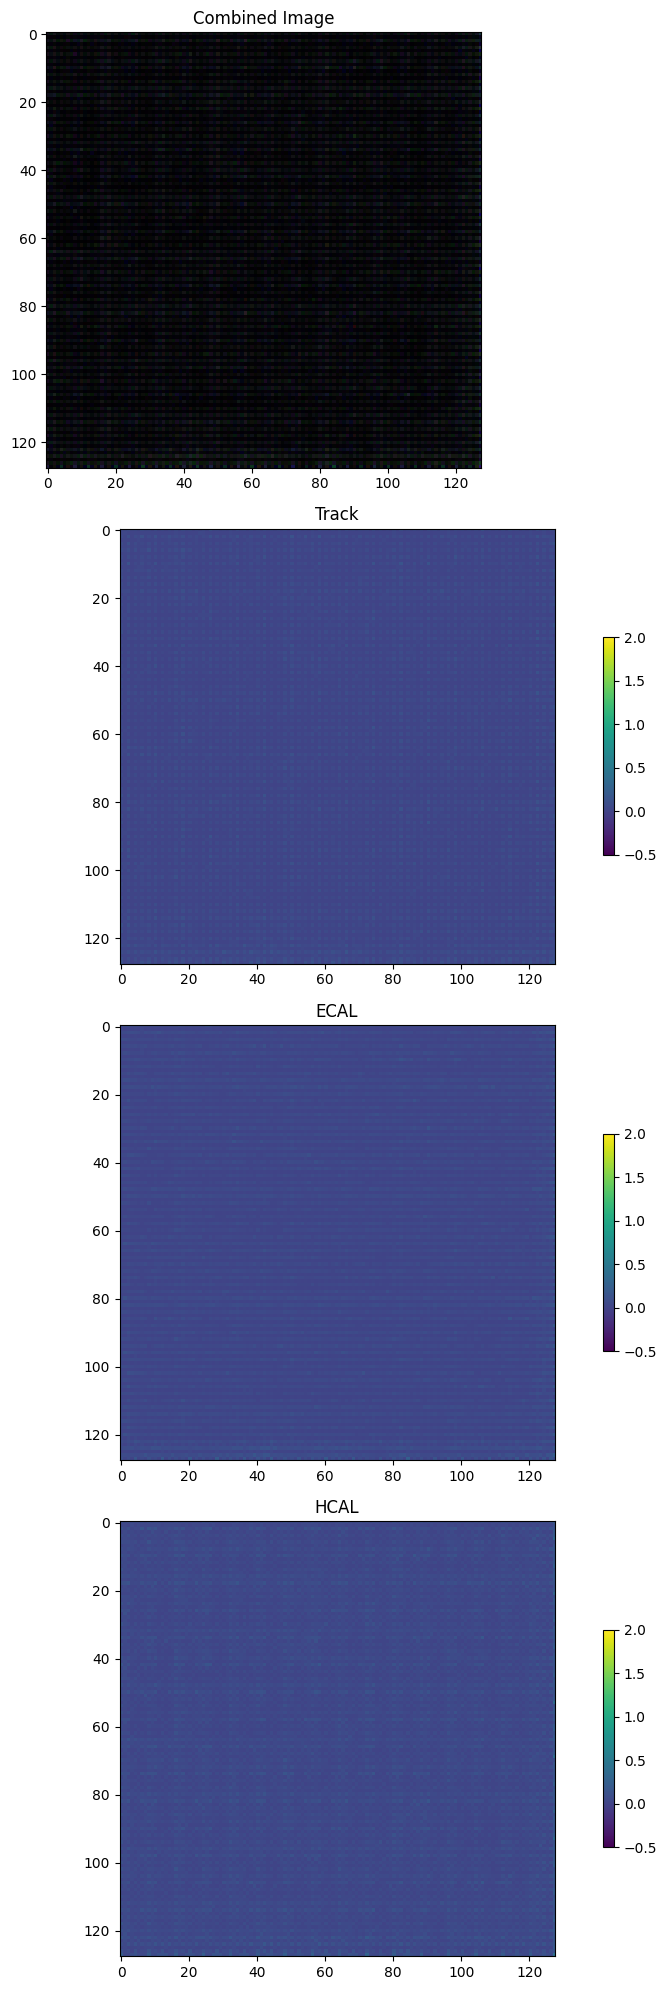

In [23]:
X_sample = x_rec

print("For the first image among the batch passed : ")
for i, label in enumerate(["Track", "ECAL", "HCAL"]):
    print(f"Max value of intensity along {label} channel: {np.max(X_sample[:,:,i])}, Min value: {np.min(X_sample[:,:,i])}")

fig, axs = plt.subplots(4, 1, figsize=(10, 20))

axs[0].imshow(X_sample)
axs[0].set_title('Combined Image')

channel_labels = ['Track', 'ECAL', 'HCAL']
for i in range(3):
    img = axs[i+1].imshow(X_sample[:, :, i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axs[i+1].set_title(channel_labels[i])
    fig.colorbar(img, ax=axs[i+1], shrink=0.5)

plt.tight_layout()
plt.show()

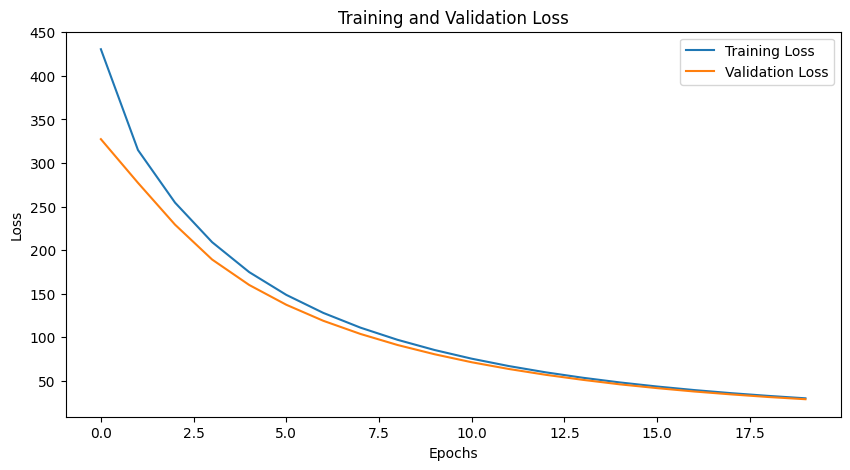

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()